## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [4]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=8000, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=500, # Experience Buffer Size
    traceLength=15,     # Number of steps each sampled episode should contain
    batchSize=40,     # Number of episodes sampled from experience buffer
    updateInterval=4, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.05)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.0, costProfile=COST_PRESETS.COAL_2, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
            GeneratorSpecs(id_="G2", basePower=1.0, costProfile=COST_PRESETS.OIL_2, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
            GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.OIL_ALTERNATE_2, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='3Gens-Cost-8k-CostProfiles_2'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=3.0, noiseLevel=0.05)], generators=[GeneratorSpecs(id_='G1', basePower=1.0, costProfile=CostProfile(alpha=510.0, beta=7.7, gamma=0.00142), minPower=0.5, maxPower=5.0, noiseLevel=0.05), GeneratorSpecs(id_='G2', basePower=1.0, costProfile=CostProfile(alpha=310.0, beta=7.85, gamma=0.00194), minPower=0.5, maxPower=5.0, noiseLevel=0.05), GeneratorSpecs(id_='G3', basePower=1.0, costProfile=CostProfile(alpha=78.0, beta=7.55, gamma=0.00482), minPower=0.5, maxPower=5.0, noiseLevel=0.05)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=8000, maxSteps=100, bufferSize=500, traceLength=15, batchSize=40, updateInterval=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), modelName='3Gens-Cost-8k-CostProfiles_2')

Train Agents

In [5]:
def rewardFn(totalCost, outputDifferential):
    scaledCost = totalCost/(100000.0) # Scale down cost to levels near the ones found in output differential (e.g. 0.1 */ 0.01)
    costComponent = 2**(-1*(scaledCost**2)*200)
    outputComponent = 2**(-1*(outputDifferential**2)*500)
    earnedReward = costComponent*outputComponent
    
    print(f'Scaled_Cost:{scaledCost} - OutputDiff:{outputDifferential} - costComponent:{costComponent} - outputComponent:{outputComponent} - reward:{earnedReward}')

    return earnedReward, {'cost': costComponent, 'output': outputComponent, 'total':earnedReward}

In [6]:
from learning.cost import ModelAdapterCost as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [8]:
%%time
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0917 23:38:43.364227 140699291617024 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0917 23:38:43.365737 140699291617024 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0917 23:38:43.403753 140699291617024 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Training model: 3Gens-Cost-8k-CostProfiles_2 - 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
Model saved in path: /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/models/3Gens-Cost-8k-CostProfiles_2/model
CPU times: user 1d 8h 15min 23s, sys: 4h 30min 25s, total: 1d 12h 45min 48s
Wall time: 15h 28min 32s


In [7]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

W0919 01:23:37.325928 140512516441856 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0919 01:23:37.327087 140512516441856 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0919 01:23:37.361056 140512516441856 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Scaled_Cost:0.03343714447720463 - OutputDiff:0.020855733490925937 - costComponent:0.8564206418961908 - outputComponent:0.8600659470271087 - reward:0.7365782304260117
Scaled_Cost:0.03371850948063573 - OutputDiff:0.030375991506199972 - costComponent:0.854180236735458 - outputComponent:0.7263060839287714 - reward:0.6203963027126813
Scaled_Cost:0.033331624744752146 - OutputDiff:0.013573225291467287 - costComponent:0.8572575191053834 - outputComponent:0.9381456171647082 - reward:0.8042323843302066
Scaled_Cost:0.03281560164962638 - OutputDiff:-0.008677066039814723 - costComponent:0.8613235948397169 - outputComponent:0.9742434705346058 - reward:0.8391388882899885
Scaled_Cost:0.03221994307471479 - OutputDiff:-0.03435389329876863 - costComponent:0.8659616580449617 - outputComponent:0.6642991656876654 - reward:0.5752576069567755
Scaled_Cost:0.03224239219178432 - OutputDiff:-0.033988954702838386 - costComponent:0.8657879516299469 - outputComponent:0.6700661714731058 - reward:0.580135218056221
Sca

Scaled_Cost:0.06984827877502238 - OutputDiff:1.3525769203284546 - costComponent:0.5084731820557148 - outputComponent:4.346913797842059e-276 - reward:2.210289090910644e-276
Scaled_Cost:0.06991000628285388 - OutputDiff:1.3548522265979146 - costComponent:0.5078654388050123 - outputComponent:5.140128139407987e-277 - reward:2.610493433034429e-277
Scaled_Cost:0.06995704718404229 - OutputDiff:1.3565850683984848 - costComponent:0.5074024216008944 - outputComponent:1.0087428047371995e-277 - reward:5.1183854189613325e-278
Scaled_Cost:0.06993422387469818 - OutputDiff:1.355744447706149 - costComponent:0.5076270544890786 - outputComponent:2.2231087761167643e-277 - reward:1.1285101598289737e-277
Scaled_Cost:0.0698665682832579 - OutputDiff:1.353251252958353 - costComponent:0.5082930914011183 - outputComponent:2.3096550066078475e-276 - reward:1.1739816833787731e-276
Scaled_Cost:0.06977712856856762 - OutputDiff:1.349952235353066 - costComponent:0.5091739322318025 - outputComponent:5.0795730023107885e-2

Scaled_Cost:0.06973544757261296 - OutputDiff:1.3484136268969549 - costComponent:0.5095845598210064 - outputComponent:2.1415322426542477e-274 - reward:1.0912917652154574e-274
Scaled_Cost:0.06974345610827361 - OutputDiff:1.3487093120098268 - costComponent:0.5095056556918663 - outputComponent:1.624385267880558e-274 - reward:8.276334810076917e-275
Scaled_Cost:0.06975311596760231 - OutputDiff:1.3490659288474574 - costComponent:0.5094104860927626 - outputComponent:1.1638118255808044e-274 - reward:5.92857947789623e-275
Scaled_Cost:0.06976175205089313 - OutputDiff:1.3493847161112507 - costComponent:0.5093254066997849 - outputComponent:8.637836785826935e-275 - reward:4.399469733947666e-275
Scaled_Cost:0.06976775261210762 - OutputDiff:1.3496061981414373 - costComponent:0.5092662936295174 - outputComponent:7.021508747642327e-275 - reward:3.5758177355990415e-275
Scaled_Cost:0.06977006498048045 - OutputDiff:1.3496915439784876 - costComponent:0.5092435143688978 - outputComponent:6.482697032801081e-2

Scaled_Cost:0.06975329382380178 - OutputDiff:1.3490724944536328 - costComponent:0.5094087338843527 - outputComponent:1.1566884672966725e-274 - reward:5.892272076242305e-275
Scaled_Cost:0.06975280002385925 - OutputDiff:1.3490542656710092 - costComponent:0.5094135987195317 - outputComponent:1.1765740616599854e-274 - reward:5.993628269102694e-275
Scaled_Cost:0.06975210317192328 - OutputDiff:1.3490285409783853 - costComponent:0.5094204640097398 - outputComponent:1.2052194093618753e-274 - reward:6.139634307506712e-275
Scaled_Cost:0.06975136937756571 - OutputDiff:1.349001452306121 - costComponent:0.509427693277517 - outputComponent:1.2361371648293908e-274 - reward:6.297225044536464e-275
Scaled_Cost:0.06975078241129892 - OutputDiff:1.3489797837546647 - costComponent:0.5094334760289014 - outputComponent:1.2614381840703618e-274 - reward:6.426188389065496e-275
Scaled_Cost:0.06975046183830526 - OutputDiff:1.3489679493614204 - costComponent:0.509436634299207 - outputComponent:1.2754742709295972e-2

Scaled_Cost:0.06975185832184007 - OutputDiff:1.3490195021455755 - costComponent:0.5094228762450393 - outputComponent:1.215449046464264e-274 - reward:6.191775491791158e-275
Scaled_Cost:0.06975183925522434 - OutputDiff:1.349018798285409 - costComponent:0.5094230640873029 - outputComponent:1.2162492669147792e-274 - reward:6.195854282456627e-275
Scaled_Cost:0.0697517897035886 - OutputDiff:1.3490169690443319 - costComponent:0.5094235522648144 - outputComponent:1.2183313985392303e-274 - reward:6.20646708879614e-275
Scaled_Cost:0.06975172313208826 - OutputDiff:1.349014511498689 - costComponent:0.5094242081204351 - outputComponent:1.2211343049739644e-274 - reward:6.220753763200597e-275
Scaled_Cost:0.06975165591431734 - OutputDiff:1.3490120300934385 - costComponent:0.509424870343269 - outputComponent:1.2239709614844585e-274 - reward:6.235212483581466e-275
Scaled_Cost:0.06975160356204847 - OutputDiff:1.3490100974603747 - costComponent:0.5094253861128006 - outputComponent:1.2261848409162205e-274 

Scaled_Cost:0.06975169620188026 - OutputDiff:1.349013517345763 - costComponent:0.5094244734341551 - outputComponent:1.2222699966029936e-274 - reward:6.226542494138466e-275
Scaled_Cost:0.06975168941547007 - OutputDiff:1.3490132668192583 - costComponent:0.5094245402931964 - outputComponent:1.2225563573073444e-274 - reward:6.228002103038187e-275
Scaled_Cost:0.06975168349082696 - OutputDiff:1.349013048105652 - costComponent:0.5094245986621956 - outputComponent:1.222806409545712e-274 - reward:6.229276644243847e-275
Scaled_Cost:0.06975167950515829 - OutputDiff:1.3490129009710485 - costComponent:0.5094246379286108 - outputComponent:1.2229746552531004e-274 - reward:6.230134209481783e-275
Scaled_Cost:0.06975168144413252 - OutputDiff:1.349012972550056 - costComponent:0.5094246188260275 - outputComponent:1.2228928030882233e-274 - reward:6.229717000783105e-275
Scaled_Cost:0.06975168305994421 - OutputDiff:1.3490130321992218 - costComponent:0.5094246029072098 - outputComponent:1.2228245971404116e-27

Alternatively, one can plot the data to better inspect the progression

In [10]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

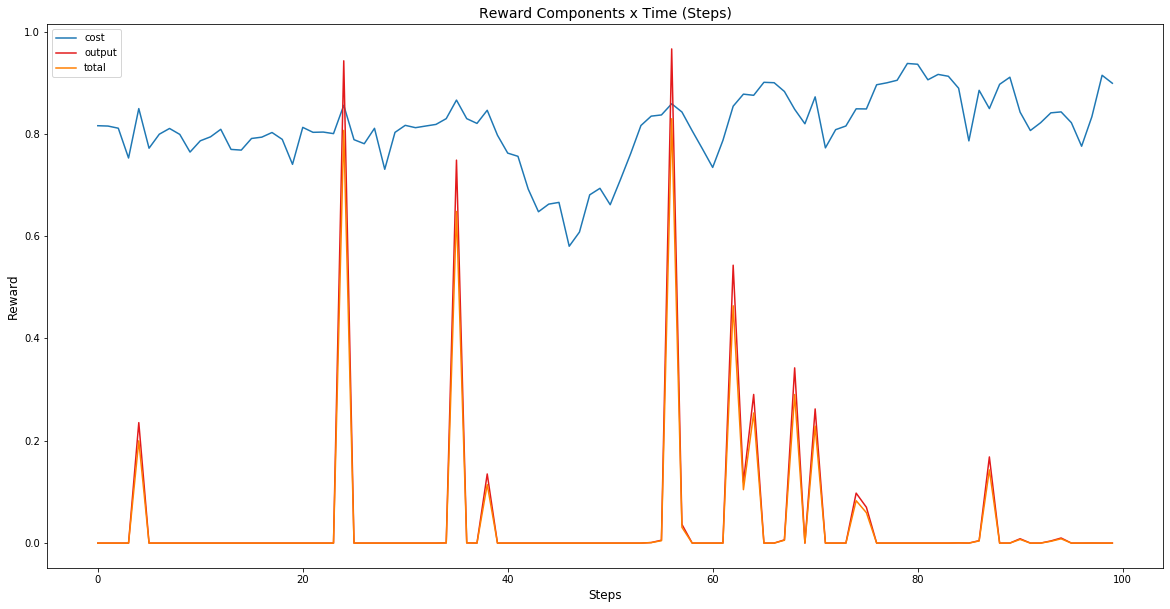

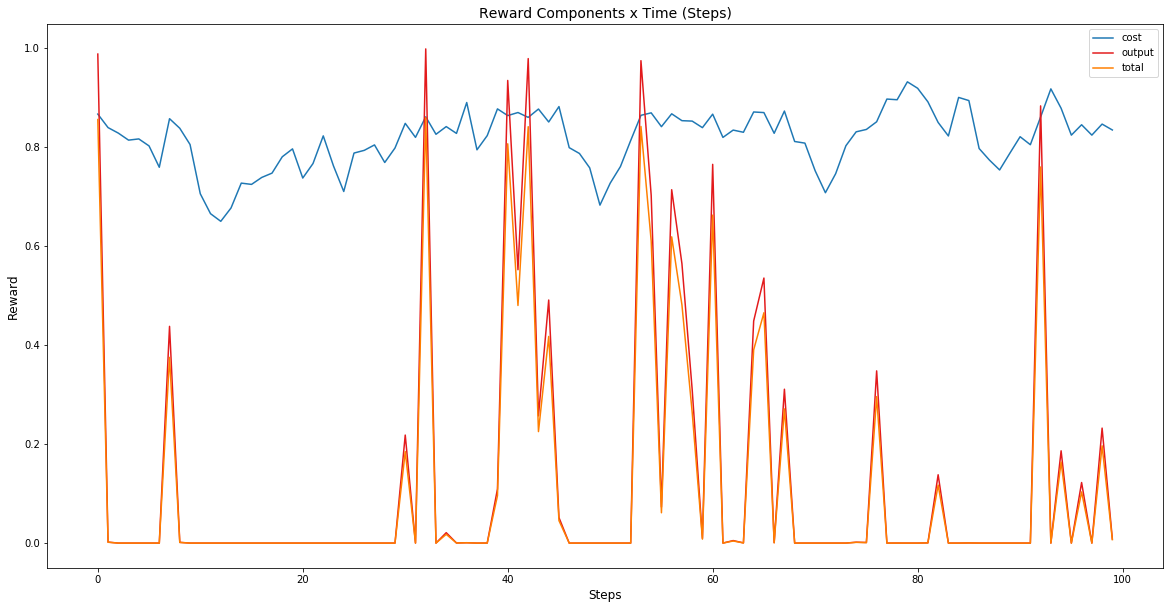

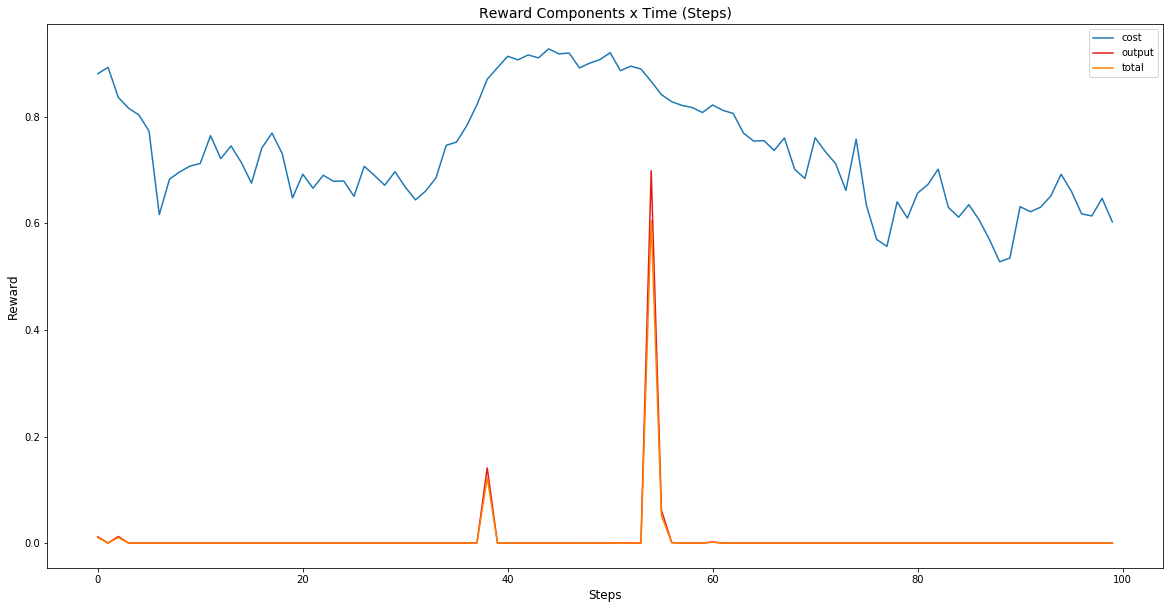

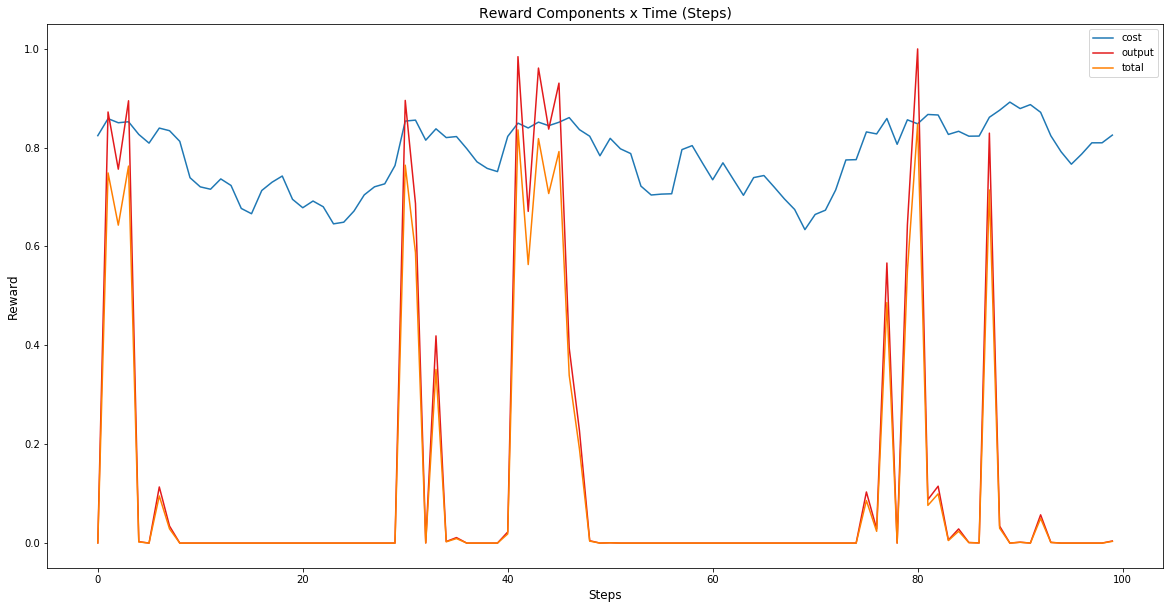

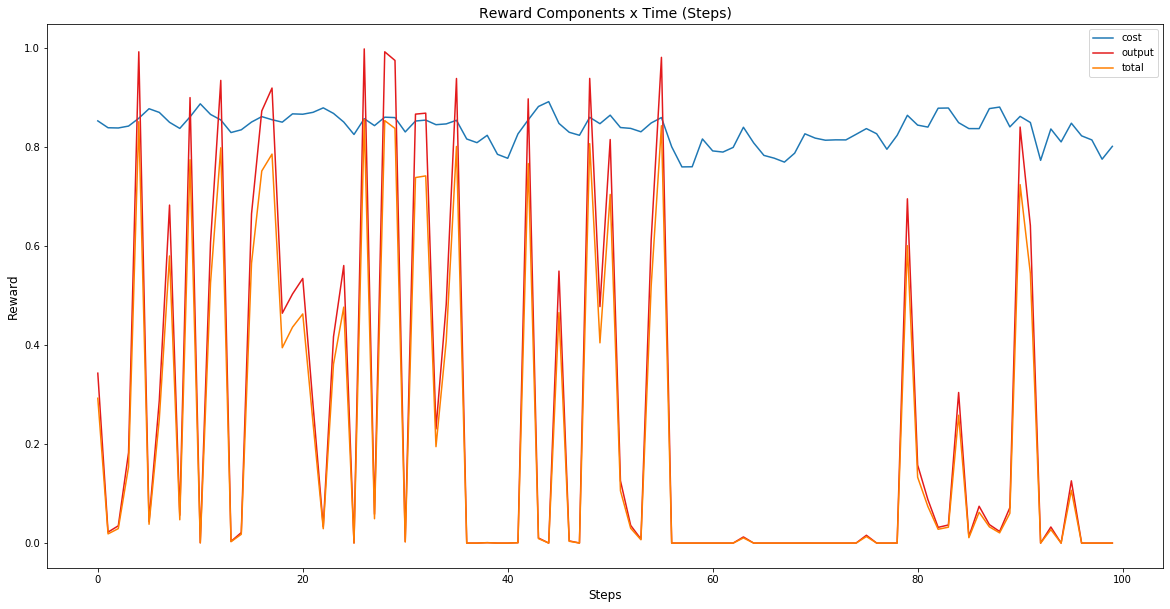

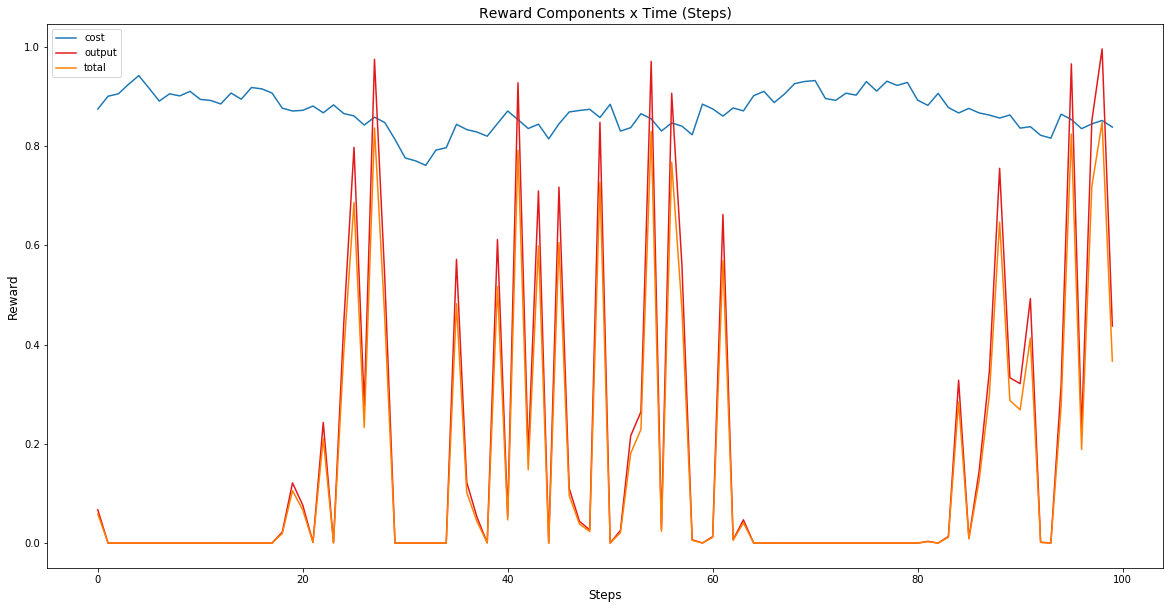

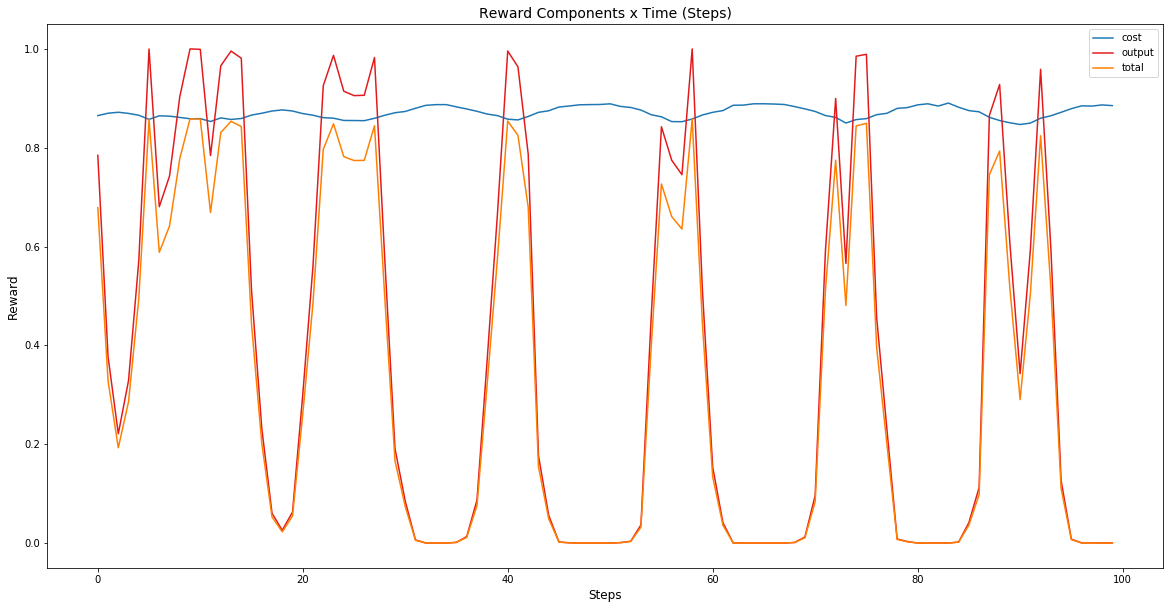

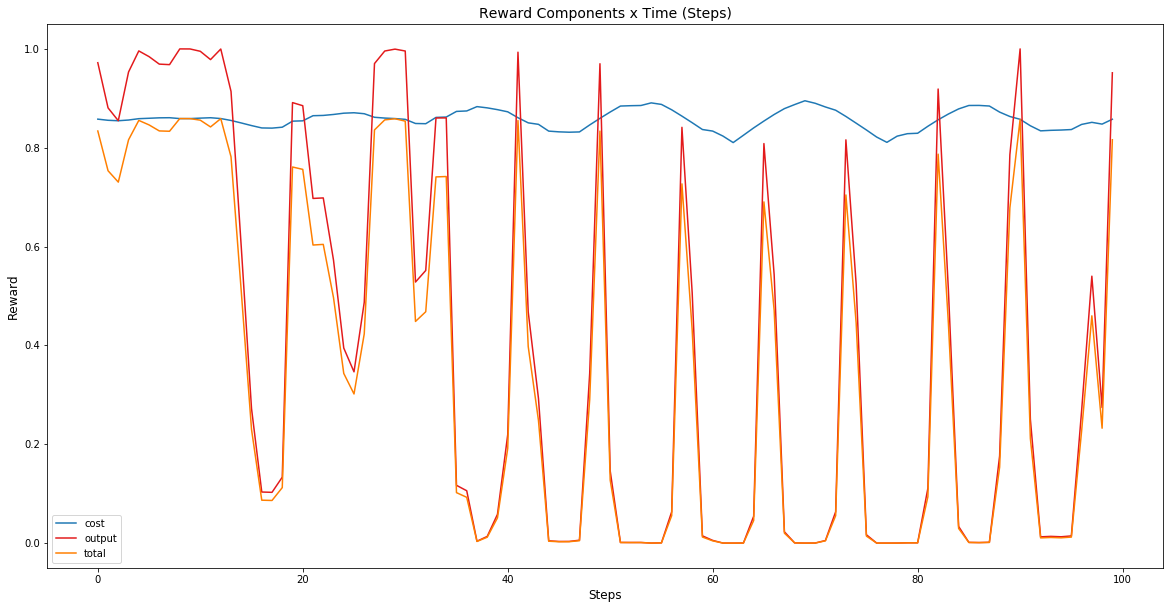

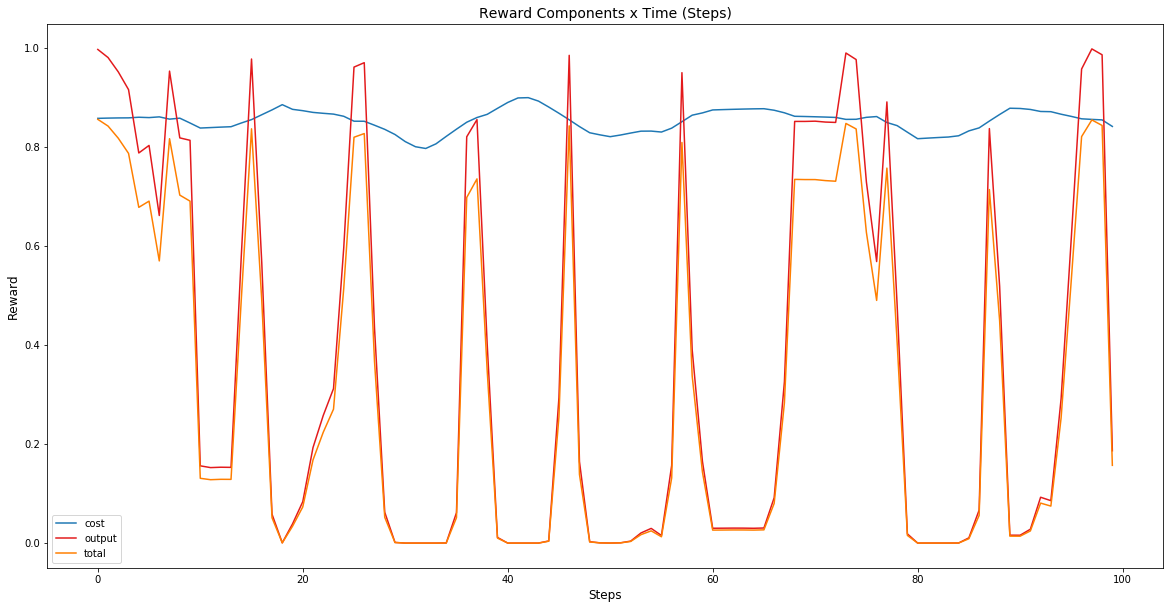

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

8.514291925232845

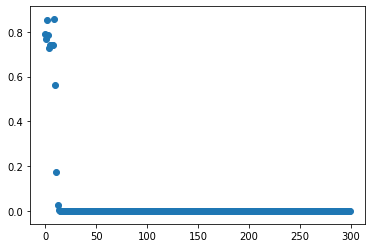

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

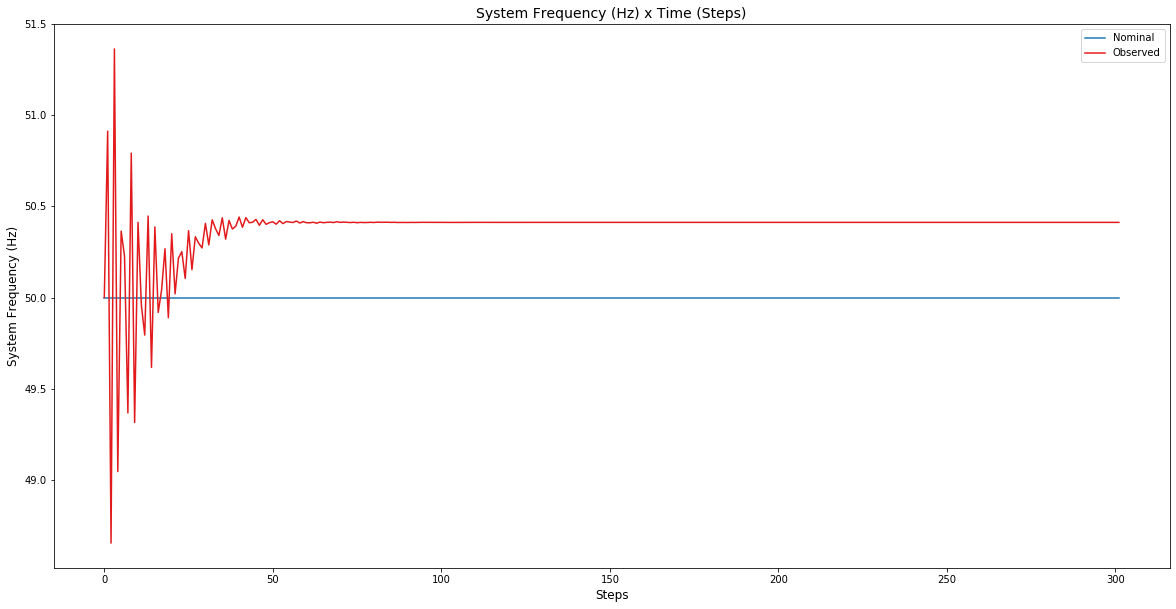

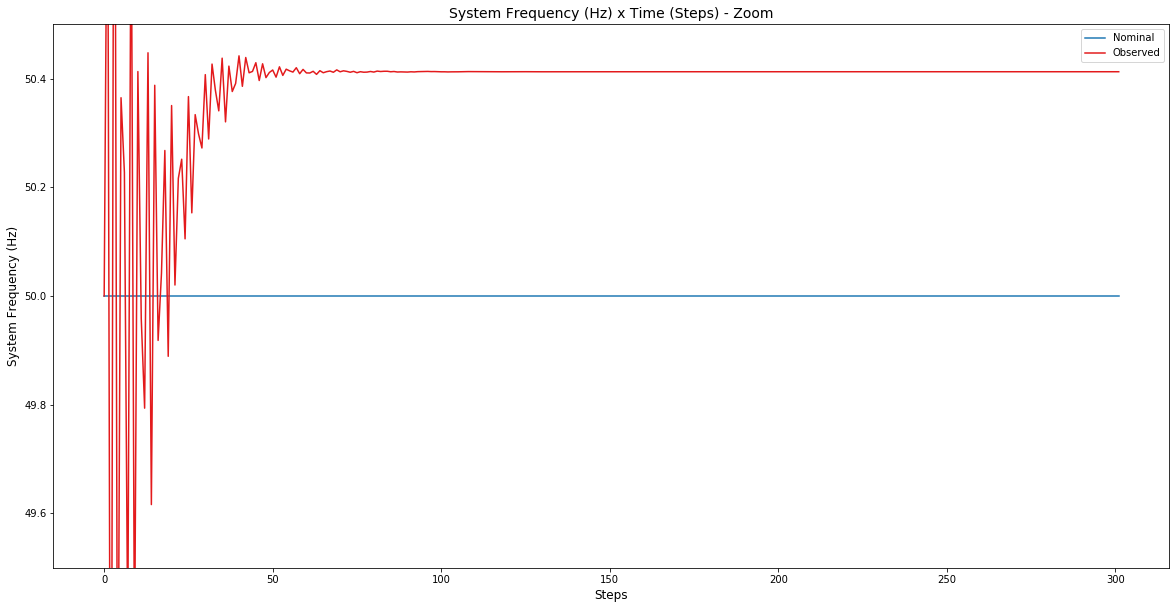

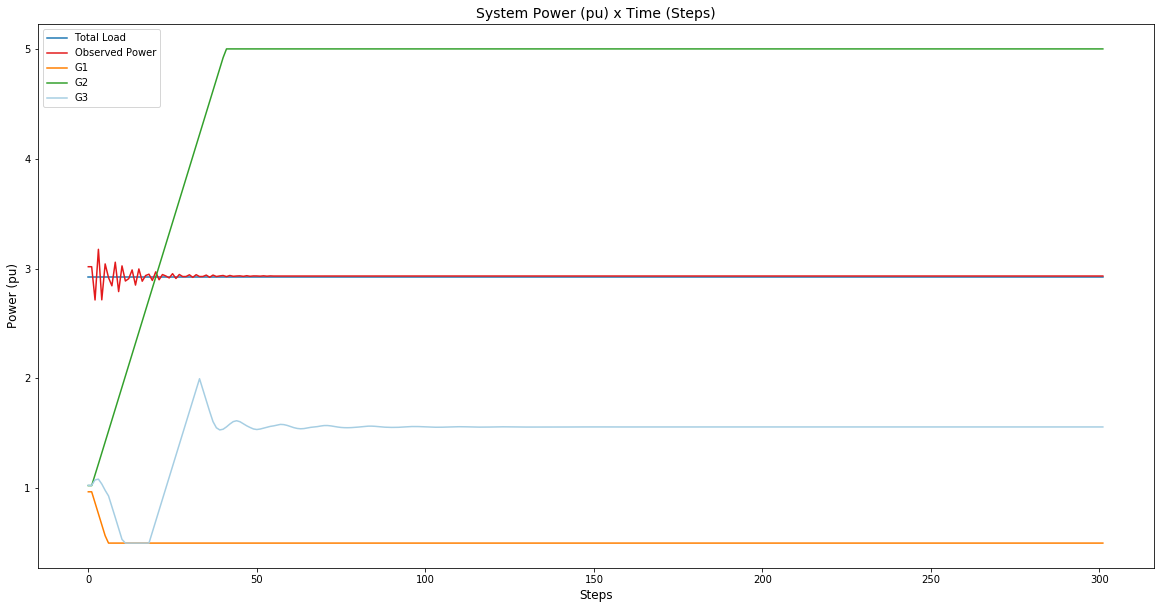

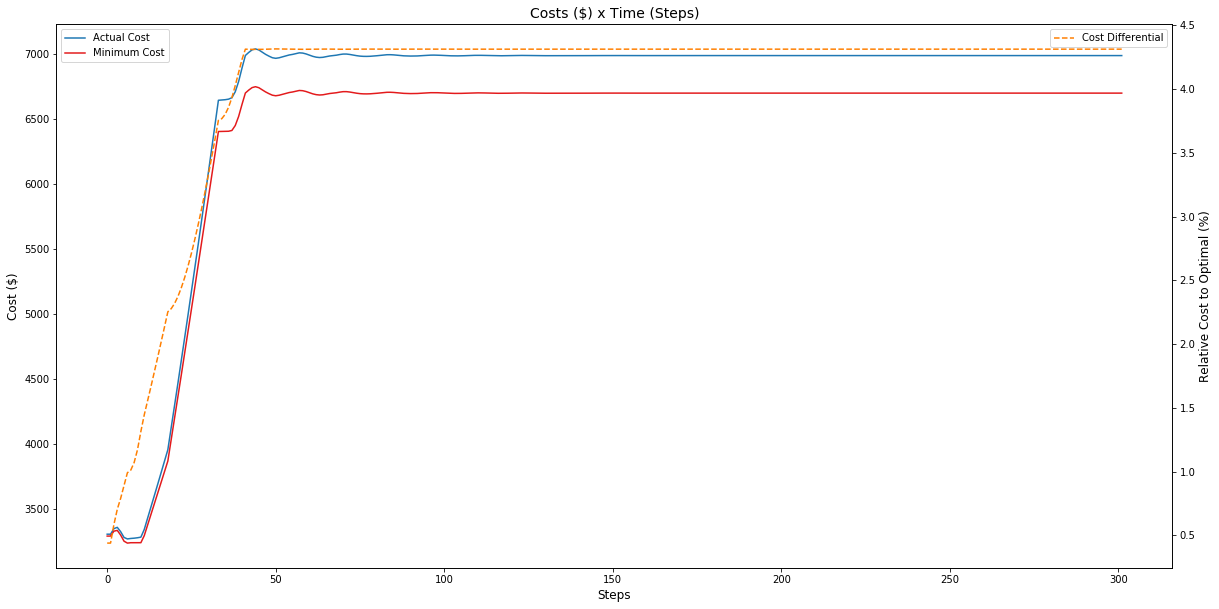

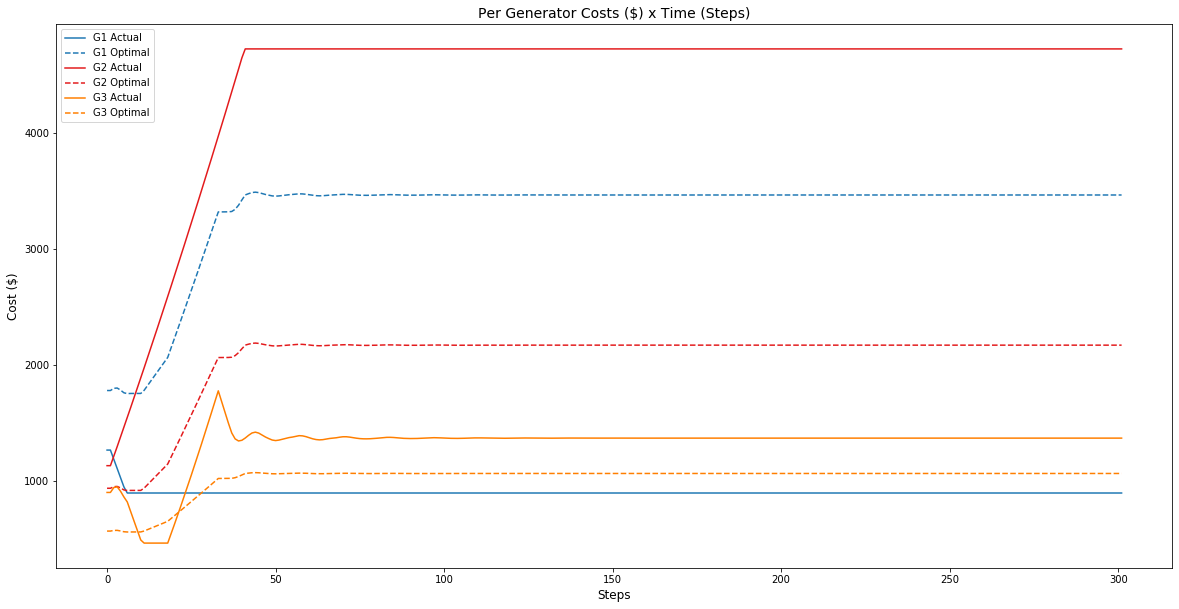

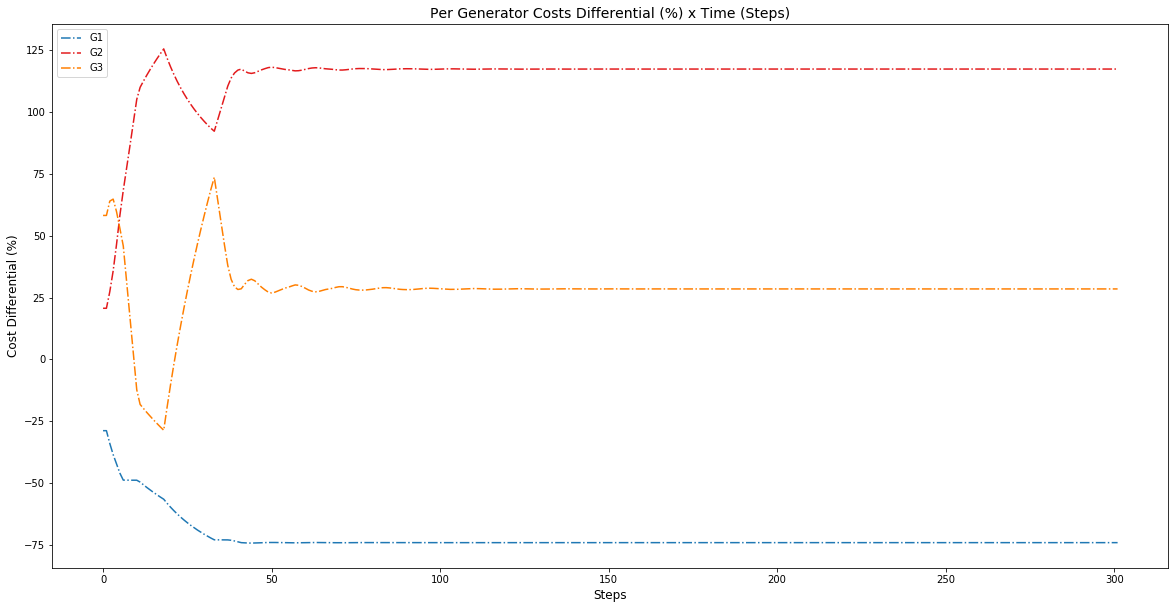

In [13]:
plotAll(electricalSystem.systemHistory)

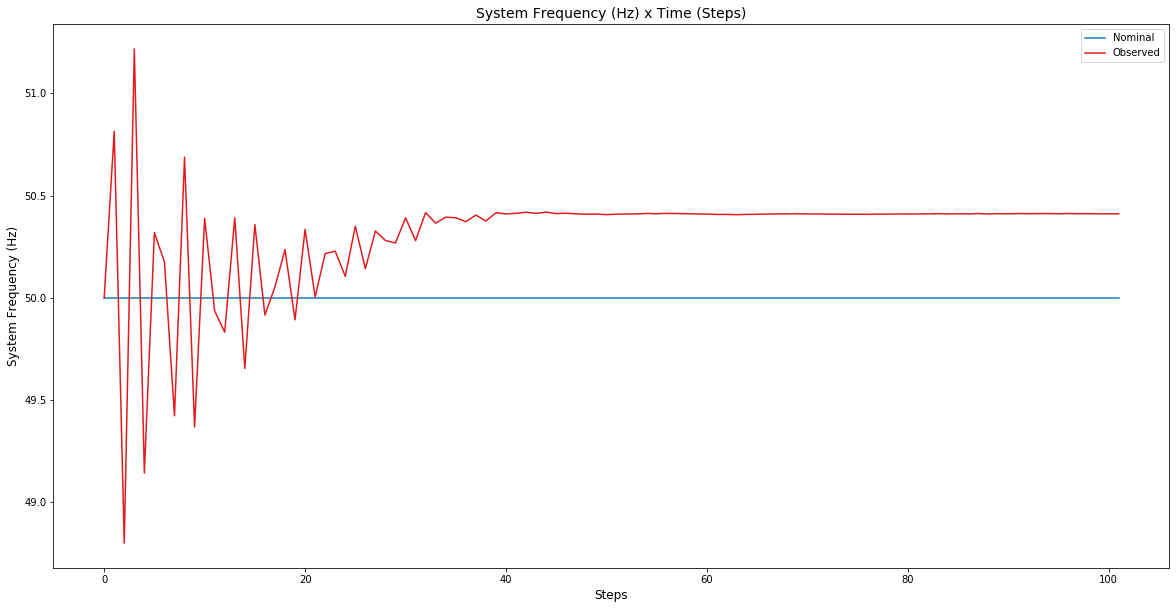

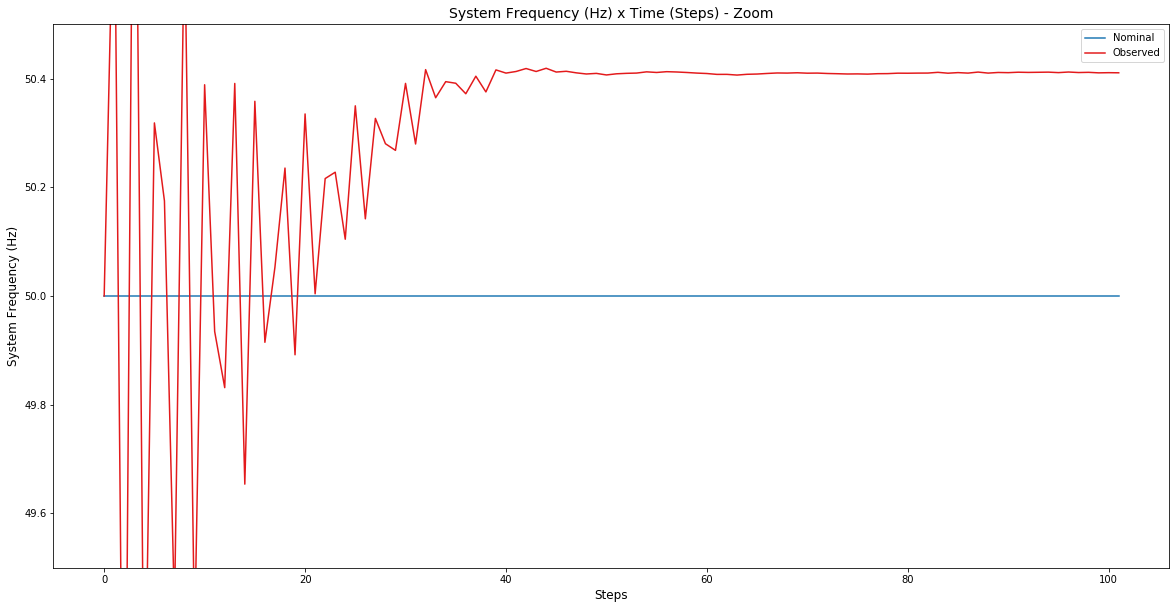

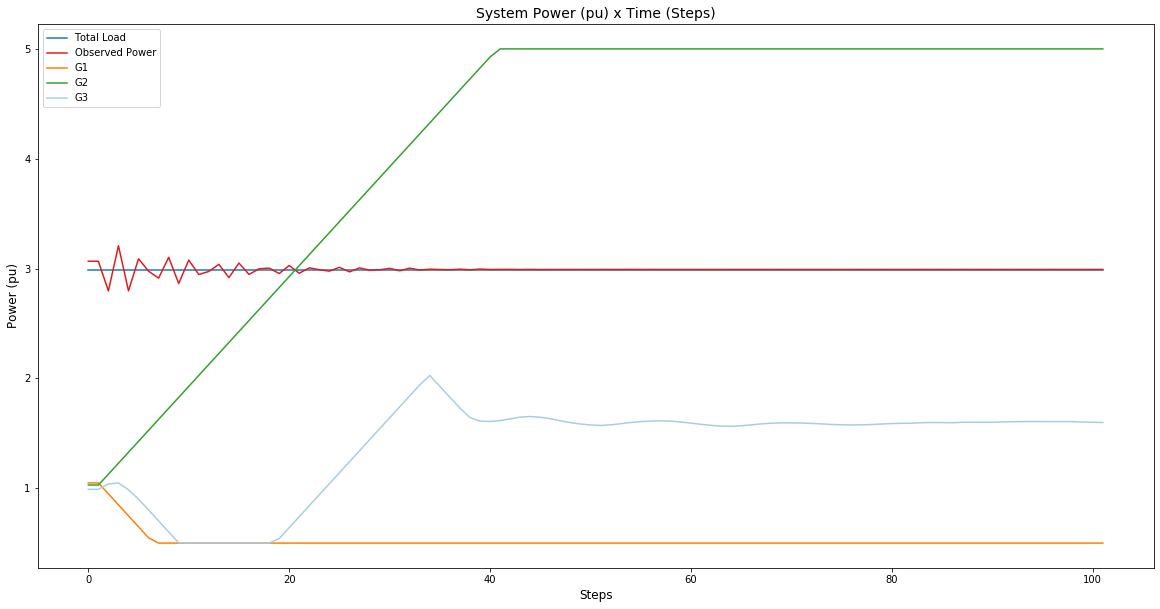

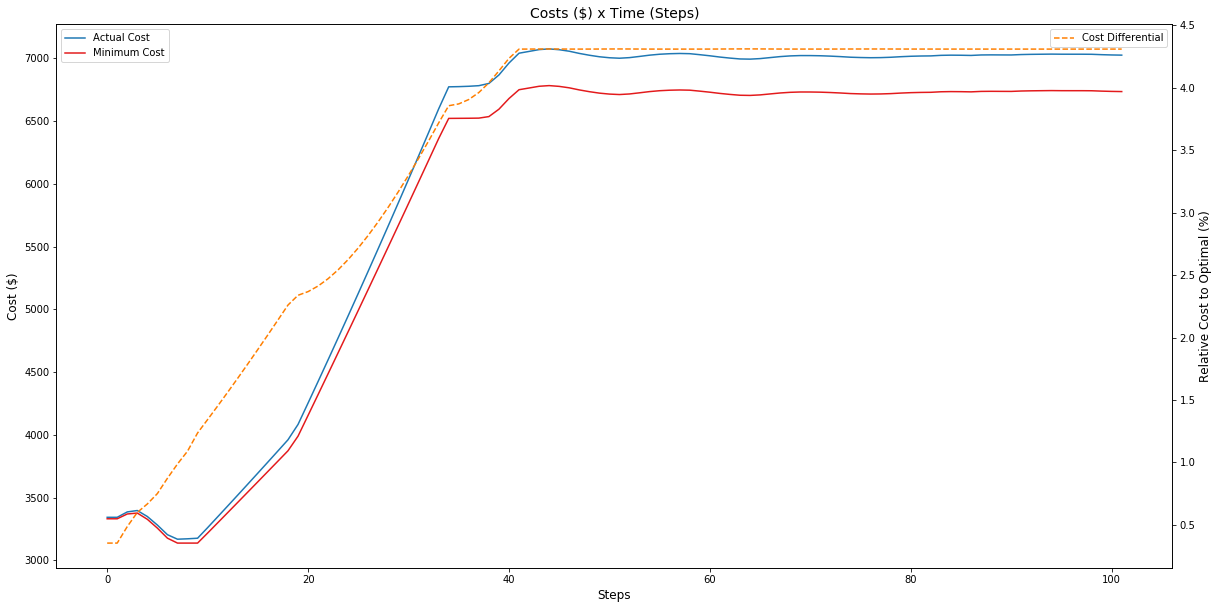

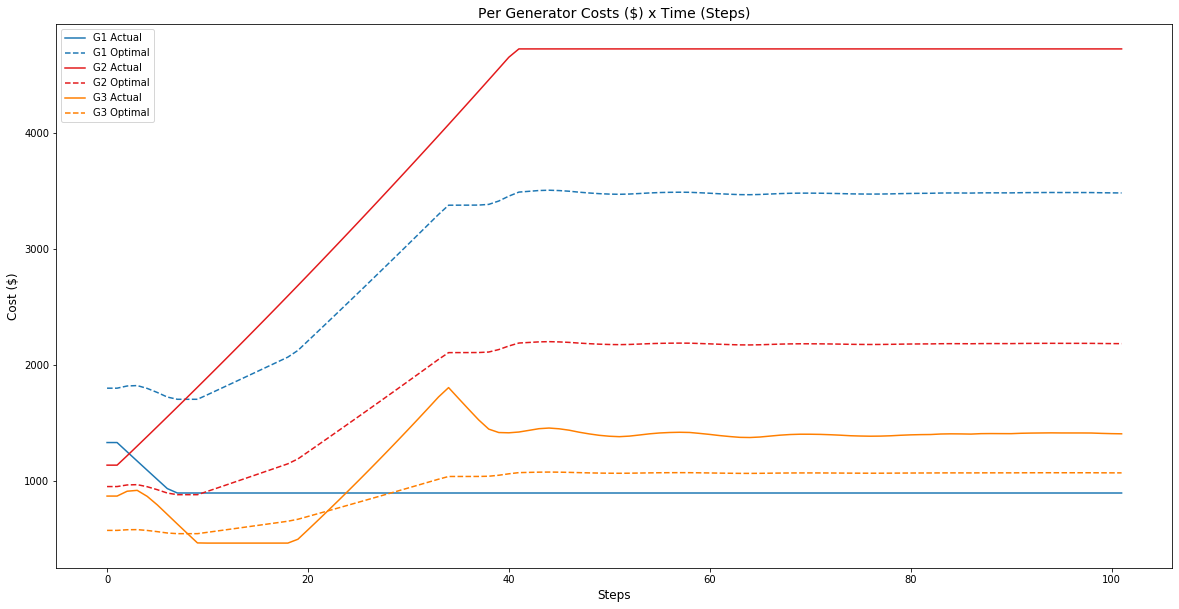

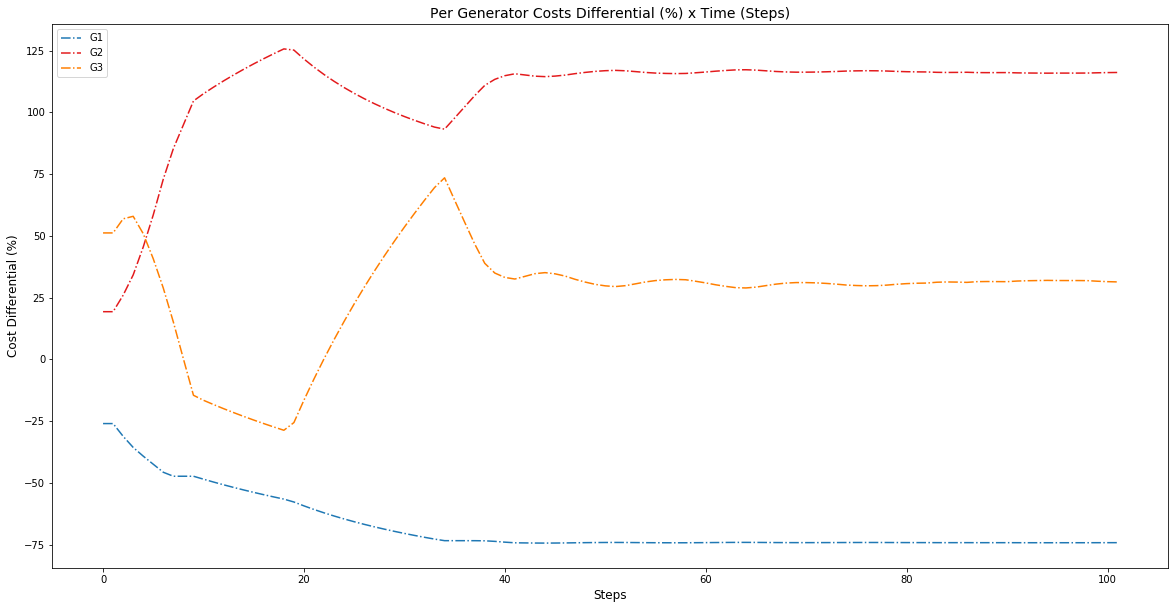

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'cost': 0.8158707406957544,
   'output': 1.93503639641622e-08,
   'total': 1.5787395780173448e-08},
  {'cost': 0.8152012490474851,
   'output': 5.684621310499431e-08,
   'total': 4.634110392681088e-08},
  {'cost': 0.81098227870936,
   'output': 1.2947411802925894e-07,
   'total': 1.0500121527325305e-07},
  {'cost': 0.7527476682265426,
   'output': 1.6101969493403547e-36,
   'total': 1.2120719990014444e-36},
  {'cost': 0.849362989263985,
   'output': 0.23547115353683074,
   'total': 0.20000048285348132},
  {'cost': 0.7718984148402696,
   'output': 3.980833818827577e-25,
   'total': 3.0727993144955437e-25},
  {'cost': 0.7992651147960947,
   'output': 2.032063706483561e-12,
   'total': 1.6241576316355611e-12},
  {'cost': 0.8104971115503065,
   'output': 1.4932946155756926e-09,
   'total': 1.2103109726177242e-09},
  {'cost': 0.7988916980129154,
   'output': 8.774224673167561e-13,
   'total': 7.00965524789365e-13},
  {'cost': 0.7643514574430692,
   'output': 6.878211924464896e-31,
   'to

TypeError: float() argument must be a string or a number, not 'dict'

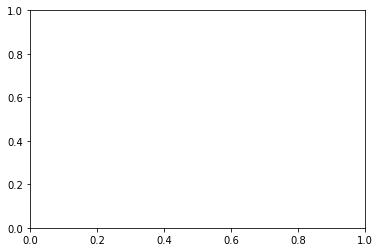

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()